# F215611

# Part 1: Data Pre Processing

*   Importing drive data
*   Loading data from drive and Cleaning it
*   Creating Vocabulary

## Importing libraries, getting drive access of files anf folders

In [1]:
# Code below was adapted from labs
# Importing few libraries for Loading and cleaning documents
from google.colab import drive
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Import few libraries for Creating Vocabulary
from collections import Counter

# Import Few Libraties for Document Word Vector preperation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Import Few Libraries for Tuning n_components value of SVD block
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt

# Import Few Libraries For Testing System Block
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

#Supress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Mount your Google Drive at the specified mountpoint path to import the required data in the runtime
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Accessing folder/files on the drive data path
data_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"
filename = data_path+'JewelleryReviewsLSA.csv'
filename2 = data_path+'JewelleryReviewsQueryRelevantID.csv'
!ls "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"

JewelleryReviewsLSA.csv		     JewelleryReviewsSummarisationTargets.csv
JewelleryReviewsQueryRelevantID.csv


## Loading and Cleaning data

Here I read the file JewelleryReviewsLSA.csv and get all the reviews and store it in a list of strings then I clean and scan all the reviews and build the vocabulary incrementally.

Had to convert the string to lower case as some of the stop words were not getting removed just because of first letter in the word being capital.

In [4]:
# Code below was adapted from labs
# This function load doc into memory
def load_csv(filename):
  
  # open the file as read only
  reviews = pd.read_csv(filename)
  documents = []
  ratings = []

  # read all text
  for d in reviews.iloc[:,1]:
    documents.append(d.lower())
  return documents

# accept a doc and return all the cleaned list of words
def clean_doc(doc):
	# split into document text by white space
	words = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	words = [w.translate(table) for w in words]
	# remove remaining words that are not alphabetic
	words = [word for word in words if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	words = [w for w in words if not w in stop_words]
	# filter out short tokens
	words = [word for word in words if len(word) > 2]
	return words

# Building path to data file
# Then calling both the functions to load and clean documents
filename = data_path+'JewelleryReviewsLSA.csv'
documents = load_csv(filename)

# clean the documents
clean_documents=[]
for d in documents:
  clean_documents.append(clean_doc(d))

# Example of a cleaned document
print("Example of a cleaned document: ",' '.join(clean_documents[0]))

Example of a cleaned document:  expect like regular size ringbut one look like ring toy something funy rings ring may cttw round diamond solitaire ring white gold


## Creating vocabulary

Creating the vocabulary and saving it to a text file for future use

In [5]:
# Code below was adapted from labs
# save file function to save the vocabulary to a file
def save_list(lines, filename):
	data = '\n'.join(lines)
	# open file
	file = open(filename, 'w')
	# write text
	file.write(data)
	# close file
	file.close()


# scan documents and add create a vocabulary by adding all the documents to
# a dictionary
def add_docs_to_vocab(documents, vocab):
  for d in documents:
    vocab.update(d)
  return vocab

# Initialise Vocabulary 
vocab = Counter()

# adding all documents to vocabulary
vocab = add_docs_to_vocab(clean_documents,vocab)

# To remove words with frequencies less than 3
# vocab = {k:v for k, v in vocab.items() if v > 2}

# save tokens to a vocabulary file
save_list(vocab, 'vocab.txt')

# Part 2: Latent Semantic Indexing (LSI) 

I have created an app which accepts a query and based on LSI it brings the closest 10 results from the dataset of reviews

LSI model has a few steps:

*   Review Vector preperation.
*   Tuning n_components value.
*   Using SVD(singular value decomposition) to tranform document vectors to a reduced dimention.
*   Testing the LSI model on the 8 given queries.





### Review Vector preperation

First I clean the reviews to a cleaned review below and then i apply TFIDF Vectorizer to convert into Review vector

In [6]:
# Code below was adapted from labs
# load doc, clean and return document as a single line of tokens and do it for
# all the documents to return a list of such lines
def docs_to_lines(filename,vocab):
	# load the docs
  docs = load_csv(filename)
  print('Original Review: ',docs[0])
  clean_documents=[]
  lines=[]
  
  # Doing the below process for all the document
  # 1. Clean document and convert them to clean tokens
  # 2. Convert all the documents to clean lines from these list of clean tokens
  for d in docs:
    doc = clean_doc(d)
    cleaned_doc = [w for w in doc if w in vocab]
    clean_documents.append(' '.join(cleaned_doc))
  return clean_documents

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = open(vocab_filename,'r')
vocab = vocab.read().split()
vocab = set(vocab)

# Creating document word vectors from vocab
documents = docs_to_lines(filename,vocab)
print('Final Document Vector example: ',documents[0])

Original Review:  i expect like regular size of ring,but this one look like a ring for toy or something funy, the mm of our rings is 5mm and this ring may be is 1mmso ridiculousmartin1/5 ct.tw round diamond solitaire ring in 18k white gold
Final Document Vector example:  expect like regular size ringbut one look like ring toy something funy rings ring may cttw round diamond solitaire ring white gold


### TFID Vectorization

I tried N-Grams and Count-vectorization technique to see if there is an improvement in the precision and recall of the system but TFIDF performed the best

In [7]:
# Using TfidfVectorizer to convert word document vectors to corresponding tfidf
# vectors used for LSI
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
transformer = TfidfTransformer(norm='l2')
tfidf_X = transformer.fit_transform(tfidf_vectorizer.fit_transform(documents))
print('TFIDF Document Vector shape: ',tfidf_X.shape)
print('Document Word Vector 0th position: ',documents[0])
print('TFIDF Vector 0th position: \n',tfidf_X[0])

TFIDF Document Vector shape:  (200, 1095)
Document Word Vector 0th position:  expect like regular size ringbut one look like ring toy something funy rings ring may cttw round diamond solitaire ring white gold
TFIDF Vector 0th position: 
   (0, 213)	0.29143477776354465
  (0, 252)	0.16409086001173778
  (0, 313)	0.23703515583841775
  (0, 376)	0.33861122217507283
  (0, 395)	0.21897870141251852
  (0, 524)	0.134120106610599
  (0, 536)	0.08475655945742976
  (0, 573)	0.21897870141251852
  (0, 632)	0.0866251635900232
  (0, 765)	0.29143477776354465
  (0, 782)	0.08679387607263346
  (0, 783)	0.33861122217507283
  (0, 787)	0.08124020695984417
  (0, 793)	0.33861122217507283
  (0, 862)	0.12954870421577747
  (0, 885)	0.29143477776354465
  (0, 887)	0.19194240262866433
  (0, 1000)	0.29143477776354465
  (0, 1058)	0.19194240262866433


### Part 2a: Two Best models for LSI(Evaluation)



*   Best Model is made from TFIDF vectors and has n_component=30 and gives me a precision of 75-90 % and a recall of 50-65 %
*   second best model has TFIDF vectord and n_component of 15 and gives me a precision of 60-75 % and recall of 35-45 %
*   I also Tried N-gram and Count Vectorisation techniques bur TFIDF outperfomed them both
*   Graph can be seen at the end that interplots average Precision and average Recall for the 8 queries on this dataset.
*   We can also see the performance of TFIDF LSI information retrival system on the 8 queries given in the data set. I tried to bring top 10 reviews relavant to these queries and also plot the average precision/recall interplot graph.






In [8]:
# Best performing model
SVD_model = TruncatedSVD(n_components=30)
lsi_x_transformed = SVD_model.fit_transform(tfidf_X)

# 2nd Best performing model
SVD_model2 = TruncatedSVD(n_components=15)
lsi_x_transformed2 = SVD_model2.fit_transform(tfidf_X)

# Takes a Query string and returns a clean string of tokens as a line
def query_to_line(query,vocab):
  # convert string to lower case
  query_lower = query.lower()
  # Cleaning the query to return clean tokens
  clean = clean_doc(query_lower)
  # only keeping tokens that are in vocab
  clean = [w for w in clean if w in vocab]
  return ' '.join(clean)

# Interplot Precision for standard Recall
def InterplotPrecision(p=0.1, Precision=None, Recall=None):
    if p >= 1.0:
        p = 0.9
    # Initialising left and right point of recall
    Mark = np.zeros(2)
    l = 0
    r = 0
    for i in range(len(Recall)):
      if Recall[i] >= p and Mark[0] == 0:
          l = i
          Mark[0] = 1
      if Recall[i] >= p + 0.1 and Mark[1] == 0:
          r = i
          Mark[1] = 1
    y = max(Precision[l:(r+1)],default=0)
    return y

# compute Recall, Precision
def compute_R_P_F1(re_mark=None, QuRe_ID =None):
  Recall = []
  Precision = []
  F1measure = []
  for i in range(len(re_mark)):
    # for all values in the retrieved result calculate recall and precision
    r = sum(re_mark[:(i+1)])
    Re = r/(len(QuRe_ID))
    Pr = r/(i+1) 
    # adding values to respective list
    Recall.append(Re)
    Precision.append(Pr)
  return Recall, Precision, F1measure

def compute_RP_yaxis(Precision=None, Recall=None):
  y_axis = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  for i in range(11):
    pInput = 0.1 * i
    #calling function to find y-axis of Interplot between recall and precision
    y_axis[i] = InterplotPrecision(p=pInput, Precision=Precision, Recall=Recall)
  return y_axis

# giving file name and initialising queries list and relavant results list for
# each query
# relavant results list
def initialize_data(queires,rel_id):
  queries_relavant_id = pd.read_csv(filename2)
  for i in range(8):
    id=[]
    for j in queries_relavant_id.iloc[:,i]:
      if not pd.isna(j):
        id.append(int(j))
    rel_id.append(id)

  # queries
  for i in queries_relavant_id.iloc[0,9:17]:
    queries.append(i)
  return queries,rel_id

def get_relavant_reviews(queries,rel_id):
  j=0
  for query in queries:
    # cleaning query string
    query_string = query_to_line(query,vocab)
    vectorizer = TfidfVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm='l2')

    # Query string to TFID query vector
    query_vector = transformer.fit_transform(vectorizer.fit_transform([query_string]))

    # reducing Query vector to smaller dimension same as documents
    query_vector = SVD_model.transform(query_vector)
    # Computing cosine similarity
    similarities = cosine_similarity(lsi_x_transformed, query_vector)
    df = pd.read_csv(filename)
    REVIEW = np.array(df[['Reviews']])
    IDS = np.array(df[['ID']])

    # Filtering list of documents according to top 10 similarities
    indexes = np.argsort(similarities.flat)[::-1]
    IDS = IDS[indexes].flat[:]
    re_mark = []
    #Finding out if the result is relavant or not
    for i in range(len(indexes)):
      if (IDS[i]) in rel_id[j]:
        re_mark.append(1)
      else:
        re_mark.append(0)
    # Calculate Recall and Precision scores of all documents corresponding
    # to 6 queries
    Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=rel_id[j])
    Recall = np.array(Recall)
    Precision = np.array(Precision)
    F1measure = np.array(F1measure)


    print('\n' + 'Query%d: '%(j+1) + query)
    print()
    print("Results: ")
    print()
    for i in range(10):
      print("Top " + str(i+1) + ' result: ID: %d '%(IDS[i]), REVIEW[indexes[i]])
    print()
    print("Recall for query "+str(j+1)+" @1~10: ", np.around(Recall[:10],2))
    print("Precision for query "+str(j+1)+" @1~10: ", np.around(Precision[:10],2))

    # save all recall and precision values for each query
    AllRecall.append(Recall)
    AllPrecision.append(Precision)
    j=j+1
  return AllRecall,AllPrecision

#### Calling all the functions defined above for LSI Model


Query1: The ring is a great gift. My friend loves it

Results: 

Top 1 result: ID: 58481  ['my wife loves the ring, it was a great gift. extremelly cheap and high quality.']
Top 2 result: ID: 17273  ['My mother loved this and was a great birthday gift. These look even better in person and go great with anything.']
Top 3 result: ID: 56494  ['I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring']
Top 4 result: ID: 41876  ["I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring."]
Top 5 result: ID: 49525  ['this product made for a great gift and great memorize for my love and me. It something we will always have. a helping gift from the heart that always shows you care.']
Top 6 result: ID: 26246  ['This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.']
Top 7 result: ID: 9726  ['A great gift to your loved one and an ever better seller. The seller de

<ipython-input-9-fd4779cec0ce>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color=colour[y], label="Query%d"%(y+1))


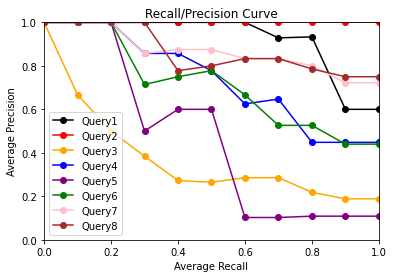

In [9]:
# Calling All the Functions

# Initialize queries list and relavant ids list
rel_id=[]
queries=[]
queries,rel_id = initialize_data(queries,rel_id)

# initialising list to save all recal and precision values of the data set
# for each query
AllRecall = []
AllPrecision = []
AllRecall,AllPrecision = get_relavant_reviews(queries,rel_id)

# calculating average recall and precision for the 6 queries @1-10
AveRecall = (AllRecall[0] + AllRecall[1] + AllRecall[3] + AllRecall[4] + AllRecall[5] + AllRecall[6] + AllRecall[7])/8
AvePrecision = (AllPrecision[0] + AllPrecision[2] + AllPrecision[3] + AllPrecision[4] + AllPrecision[5] + AllPrecision[6] + AllPrecision[7])/8
# printing average recall and precision values @1-10
print()
print("\nAverage Recall and average Precision: ")
print("Recall for query 1@1~10: ", np.around(AllRecall[0][:10],2))
print("Precision for query 1@1~10: ", np.around(AllPrecision[0][:10],2))
print()
print()


# plot R/P curve for all 8 queries
num_queries=8
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colour = ['black','red','orange','blue','purple','green','pink','brown']
for y in range(num_queries):
  y_axis = compute_RP_yaxis(Precision=AllPrecision[y], Recall=AllRecall[y])
  plt.plot(x_axis, y_axis, '-bo', color=colour[y], label="Query%d"%(y+1))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.title('Recall/Precision Curve')
plt.legend()
plt.show()

### Part 2b Tuning n_components value of SVD

I use SVD to compress TFIDF vectors to n_component dimensional data and tune the number to a number for which we preserve the variance and loose the unwanted noise.

For this I tried a way to test similarity by averaging similarity among few similar documents I chose at random, to plot and see which number works and gets maximum variance with minimum loss(here i take similarity as a measure).

I took 6 Queries of similar documents and compared the cosine similarity among each other and then averaged the similarities for each n_component to plot on a graph.I run a loop from 1-50 to plot a graph to see how the similarity changes with n_components(1-50) between 2 queries(each time comparing a document with all others)
The 6 queries i selected were 

*   I bought two of these rings to fit on either side of my own platinum princess wedding ring to help anchor and to add to the ring. Perfect fit! I have had a lot of compliments on my new ring".
*   This ring is perfect I say why spend thousands when you don't have to? The ring shines perfectly I love this ring!
*   Eve's Addiction was wonderful with sending the ring and the ring is beautiful; my daughter waas thrilled with the ring. Thank you, Dorothy
*   my girlfriend especially enjoys this ring because of the thickness of the ring band. In the past she has had similar rings but has always been frustrated by the flimsy ring band, but this ring has a nice solid band.
*   I absolutely love this ring! I got this as my engagement ring Feb 09 This ring is beautiful and durable.
*   I love this ring because the flowers go all the way around the ring and it fits my ring finger so if I ever find Mr. Right he doesn't have to buy me an engagement ring, he can just use this as my engagement ring, as I am not into getting into debt before marriage.

After Looking at the plot we can say that n_component can have a value of 20-30 with which it can get a good similarity score without loosing too much of varianec. The number came out to be 30. As below blocks will tell you how the number 30, turns out to be

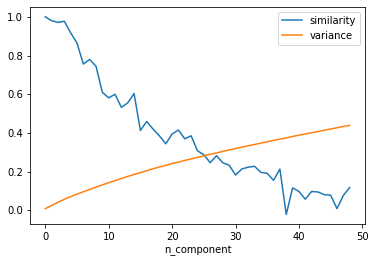

In [10]:
# Code below was adapted from labs
def build_graph_data(var_explained,similarity_for_graph):
  # running a loop from 1-50
  for n in range(1,50):
    SVD_model = TruncatedSVD(n_components=n)
    # getting transofrmed vectors
    transformed_x = SVD_model.fit_transform(tfidf_X)
    
    # comparing consine similarity of document 50 with 47,48,49,51 and 52 and then 
    # averaging the similarity to add the number for a particular n_component to
    # the list similarity_for_graph
    s1 = cosine_similarity([transformed_x[50]], [transformed_x[47]])[0][0]
    s2 = cosine_similarity([transformed_x[50]], [transformed_x[48]])[0][0]
    s3 = cosine_similarity([transformed_x[50]], [transformed_x[49]])[0][0]
    s4 = cosine_similarity([transformed_x[50]], [transformed_x[51]])[0][0]
    s5 = cosine_similarity([transformed_x[50]], [transformed_x[52]])[0][0]

    # Averaging all 5 comparisions to store a value in the list
    similarity_for_graph.append((s1+s2+s3+s4+s5)/5)
    # Calculating Variance explained by this n_component value
    var_explained.append(SVD_model.explained_variance_ratio_.sum())


# Initialise both the lists of similarity and vaeiance
similarity_for_graph=[]
var_explained=[]

# call function to populate the lists
build_graph_data(var_explained,similarity_for_graph)

# Plotting similarity v variance graph
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(similarity_for_graph,label='similarity')
plt.plot(var_explained,label='variance')
plt.xlabel("n_component")
plt.legend()

## Observations:

I Observed that the system performs really good on the review data set:

Precision:90+%
Recall:50-60+%

On all 8 queries which tell that the model learnt the relationships among multiple combination of words used together without training and just based on the TFIDF vector values for each review

## Testing System

To test this system and interact with it you can take a look at the textbox widget provided below where if you enter any query you will get a list of 10 most relavent results 

In [11]:
# Display Widget function
def create_app():
  display(text)
  display(button, textbox)
  button.on_click(find_button)

# On Click Fucntion for geting the top 10 results
def find_button(b):
  with textbox:
    if text.value!='':
      # cleaning query string
      query = query_to_line(text.value,vocab)
      # creating vectorizer
      vectorizer = TfidfVectorizer(vocabulary=vocab)
      transformer = TfidfTransformer(norm='l2')
      # Query string to TFID query vector
      query_vector = transformer.fit_transform(vectorizer.fit_transform([query]))

      # reducing Query vector to smaller dimension same as documents
      query_vector = SVD_model.transform(query_vector)
      similarities=dict()
      for count, value in enumerate(lsi_x_transformed):
        # Computing cosine similarity
        similarity = cosine_similarity([value], query_vector)
        similarities[count]=similarity

        # Filtering list of documents according to top 10 similarities
        # and saving the results in a DataFrame
        k = {c: sim for c, sim in sorted(similarities.items(), key=lambda item: item[1])}.keys()
        index = list(k)
        list.reverse(index)
        df = pd.read_csv(filename)
        columns = df.columns
        pd.options.display.max_colwidth = 150
        df = df.iloc[np.array(index),0:3].head(10)
    else:
      query=""
      clear_output(wait=True)
      print('Enter Some Value')
    # Reset the console from old result when the button is clicked
    if query !="":
      clear_output(wait=True)
      print('Transformed query: ',query)
      explained_variance = SVD_model.explained_variance_ratio_.sum()
      print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))
      display(df)


# Best Performing LSI model
SVD_model = TruncatedSVD(n_components=30)
# reducing document vector dimensions
lsi_x_transformed = SVD_model.fit_transform(tfidf_X)

# Widget to enter query and get top 10 results
textbox = widgets.Output()
button = widgets.Button(description="Get Top 10 results")
text = widgets.Textarea(
value='',
placeholder='Paste enter your query here',
description='Query:',
disabled=False
)
# Crate Widget
create_app()

Textarea(value='', description='Query:', placeholder='Paste enter your query here')

Button(description='Get Top 10 results', style=ButtonStyle())

Output()

# Part 3 Neural Network Information Retrieval

I used the BERT(pretrained model) to bring in pretrained weights on a large dataset to build a tokenizer for reviews to build tokeized review vectors and compare with the tokenized queries using cosine similarity for retrieving relavant reviews

## Importing Libraries

In [12]:
# Code below was adapted from labs
# Import Few Libraries For BERT Model Block
!pip install transformers
import transformers as ppb

# Import Few Libraries For Feature Extraction Block
import pandas as pd
import torch

# Import Few Libraries For Widget Block
from IPython.display import clear_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.1 MB/s eta 0:00:00


## BERT Model



In [13]:

# BERT Model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Feature extraction from Neural Network model

Below is the function that accepts the document


1.   Tokenizes it based on BERTokenizer
2.   takes only first 512 tokens if length greater than 512 and finds the maximum length among all lists of tokens(reviews)
3.   pad all the list of tokens(reviews) having length less than maximum length
4.   max these padded lists
5.   Create a feature vector USING these padded and masked vectors AND PASSING IT TO THE BERT Model class



In [14]:
def extract_document_features(document):
  with torch.no_grad():
    # Tokenization using BertTokenizer
    tokenized = documents_array.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    print("Example of First Document: ",documents_array[0])
    print("Example of First tokenized Document: ",tokenized.values[0])
    print("Length of First Document: ",len(documents_array[0].split()))
    print("length of First tokenized Document: ",len(tokenized.values[0]))

    # Computing maximum length and striping all vectors to first 512 values
    max_len = 0
    q = 0
    for i in tokenized.values:
        
        # BERT only accept maximum 512 values
        if len(i) > 512:
            temp = tokenized.values[q]
            tokenized.values[q] = temp[:512]
            i = tokenized.values[q]
            print('too much tokenized.values for BERT, only 512 are taken')
        if len(i) > max_len:
            max_len = len(i)
        q += 1


    # padding all doxument vectors to the maximum lenght among the documets
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # creating masks for better performance
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape

    # Converting vectors to tensors
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)
    print("Shape of input vector: ",input_ids.shape)
    
    # creating Document Feature Vector
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    train_features = last_hidden_states[0][:,0,:].numpy()
  return train_features,max_len

In [15]:
# Converting list of cleaned documents to series of documents for tokenization
documents_array = pd.Series(documents)

train_features,max_len = extract_document_features(documents)

Example of First Document:  expect like regular size ringbut one look like ring toy something funy rings ring may cttw round diamond solitaire ring white gold
Example of First tokenized Document:  [101, 5987, 2066, 3180, 2946, 3614, 8569, 2102, 2028, 2298, 2066, 3614, 9121, 2242, 4569, 2100, 7635, 3614, 2089, 14931, 2102, 2860, 2461, 6323, 14017, 29422, 3614, 2317, 2751, 102]
Length of First Document:  22
length of First tokenized Document:  30
Shape of input vector:  torch.Size([200, 79])


## Part 3a: NN Model

*   Evaluating and testing the model in given queries
* Graph can be seen at the end that interplots average Precision and average Recall for the 8 queries on this dataset just like LSI done earlier


In [16]:
# Interplot Precision for standard Recall
def InterplotPrecision(p=0.1, Precision=None, Recall=None):
    if p >= 1.0:
        p = 0.9
    # Initialising left and right point of recall
    Mark = np.zeros(2)
    l = 0
    r = 0
    for i in range(len(Recall)):
      if Recall[i] >= p and Mark[0] == 0:
          l = i
          Mark[0] = 1
      if Recall[i] >= p + 0.1 and Mark[1] == 0:
          r = i
          Mark[1] = 1
    y = max(Precision[l:(r+1)],default=0)
    return y

# compute Recall, Precision
def compute_R_P_F1(re_mark=None, QuRe_ID =None):
  Recall = []
  Precision = []
  F1measure = []
  for i in range(len(re_mark)):
    # for all values in the retrieved result calculate recall and precision
    r = sum(re_mark[:(i+1)])
    Re = r/(len(QuRe_ID))
    Pr = r/(i+1) 
    # adding values to respective list
    Recall.append(Re)
    Precision.append(Pr)
  return Recall, Precision, F1measure

def compute_RP_yaxis(Precision=None, Recall=None):
  y_axis = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  for i in range(11):
    pInput = 0.1 * i
    #calling function to find y-axis of Interplot between recall and precision
    y_axis[i] = InterplotPrecision(p=pInput, Precision=Precision, Recall=Recall)
  return y_axis

# Takes a Query string and returns a clean string of tokens as a line
def query_to_line(query,vocab):
  # convert string to lower case
  query_lower = query.lower()
  # Cleaning the query to return clean tokens
  clean = clean_doc(query_lower)
  # only keeping tokens that are in vocab
  clean = [w for w in clean if w in vocab]
  return ' '.join(clean)


# giving file name and initialising queries list and relavant results list for
# each query
queries_relavant_id = pd.read_csv(filename2)
# relavant results list
rel_id=[]
for i in range(8):
  id=[]
  for j in queries_relavant_id.iloc[:,i]:
    if not pd.isna(j):
      id.append(int(j))
  rel_id.append(id)

# queries
queries=[]
for i in queries_relavant_id.iloc[0,9:17]:
  queries.append(i)

AllRecall = []
AllPrecision = []
result=[]
def retirieve_results_using_nn_model(train_features,queries,rel_id,AllRecall,AllPrecision,max_len):
  j=0
  with torch.no_grad():
    for query in queries:
      query_string = query_to_line(query,vocab)
      query_array = pd.Series([query_string])

      # Tokenizing Query Vectors
      query_vector = query_array.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

      # padding all doxument vectors to the maximum lenght among the documets
      padded_query = np.array([i + [0]*(max_len-len(i)) for i in query_vector.values])

      # creating masks for better performance
      query_mask = np.where(padded_query != 0, 1, 0)

      # Converting query Vectors to tensors
      query_ids = torch.tensor(padded_query)  
      query_mask = torch.tensor(query_mask)
      query_hidden_states = model(query_ids, attention_mask=query_mask)

      # Extracting Features from Query Vector
      query_features = query_hidden_states[0][:,0,:].numpy()


      # Computing cosine similarity
      similarities = cosine_similarity(train_features, query_features)

      # Filtering list of documents according to top 10 similarities
      df = pd.read_csv(filename)
      REVIEW = np.array(df[['Reviews']])
      IDS = np.array(df[['ID']])
      indexes = np.argsort(similarities.flat)[::-1]
      IDS = IDS[indexes].flat[:]

      #Finding out if the result is relavant or not
      re_mark = []
      for i in range(len(indexes)):
        if IDS[i] in rel_id[j]:
          re_mark.append(1)
        else:
          re_mark.append(0)
      # Calculate Recall and Precision scores of all documents corresponding
      # to 6 queries
      Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=rel_id[j])
      Recall = np.array(Recall)
      Precision = np.array(Precision)
      F1measure = np.array(F1measure)


      print('\n' + 'Query%d: '%(j+1) + query)
      print()
      print("Results: ")
      print()
      for i in range(10):
        print("Top " + str(i+1) + ' result: ID: %d '%(IDS[i]), REVIEW[indexes[i]])
      print()
      print("Recall for query "+str(j+1)+" @1~10: ", np.around(Recall[:10],2))
      print("Precision for query "+str(j+1)+" @1~10: ", np.around(Precision[:10],2))

      # save all recall and precision values for each query
      AllRecall.append(Recall)
      AllPrecision.append(Precision)
      j=j+1
  return AllRecall,AllPrecision

### Calling functions


Query1: The ring is a great gift. My friend loves it

Results: 

Top 1 result: ID: 26246  ['This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.']
Top 2 result: ID: 36164  ['I got the ring as a promise ring for my girlfriend for Christmas and she loved it. Definitely a great value.']
Top 3 result: ID: 41876  ["I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring."]
Top 4 result: ID: 45203  ['I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.']
Top 5 result: ID: 48216  ['I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.']
Top 6 result: ID: 50650  ['Not only is the ring beautiful, the jeweler was very accommadating in having the ring reach us in time. We appreciate the care and quick receiving of the ring. Thank you!']
Top 7 result: ID: 20090  ['Not only is the ring beautiful, the jeweler was very accommadating in 

<ipython-input-17-92211f60f055>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color=colour[y], label="Query%d"%(y+1))


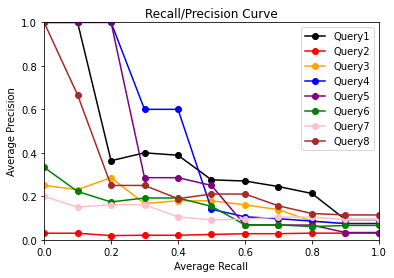

In [17]:
AllRecall,AllPrecision = retirieve_results_using_nn_model(train_features,queries,rel_id,AllRecall,AllPrecision,max_len)

# calculating average recall and precision for the 6 queries @1-10
AveRecall = (AllRecall[0] + AllRecall[1] + AllRecall[3] + AllRecall[4] + AllRecall[5] + AllRecall[6] + AllRecall[7])/8
AvePrecision = (AllPrecision[0] + AllPrecision[2] + AllPrecision[3] + AllPrecision[4] + AllPrecision[5] + AllPrecision[6] + AllPrecision[7])/8
# printing average recall and precision values @1-10
print()
# printing average recall and precision values @1-10
print("\nAverage Recall and average Precision: ")
print("Average Recall@1~10: ", np.around(AveRecall[:10],2))
print("Average Precision@1~10: ", np.around(AvePrecision[:10],2))
print()

# plot R/P curve for all 8 queries
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colour = ['black','red','orange','blue','purple','green','pink','brown']
for y in range(8):
  y_axis = compute_RP_yaxis(Precision=AllPrecision[y], Recall=AllRecall[y])
  plt.plot(x_axis, y_axis, '-bo', color=colour[y], label="Query%d"%(y+1))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.title('Recall/Precision Curve')
plt.legend()
plt.show()

### Observations

My Observation is that LSI Model is working far better than the NN(BERT) model. In terms of precision and recall we can clearly see that the LSI model learnt about the words in the reviews dataset better than the neural network model without training. 

Synonymy refers to the fact that different words can have the same or similar meanings, while polysemy refers to the fact that the same word can have multiple meanings. These issues can make it difficult to accurately represent the meaning of a document or to match documents based on their semantic content.

LSI solves this problem by using singular value decomposition (SVD) to transform the original high-dimensional space of review vectors into a lower-dimensional space that captures the underlying topics or themes present in the data. This lower-dimensional representation allows LSI to effectively handle synonymy and polysemy by identifying patterns in the relationships between words and documents, rather than relying solely on individual word meanings.

Where Neural Networks on the other hand rely on word embeddings that were learnt in some other context compared to this small dataset.

This is the reason LSI gets a precision and recall of 90+ and 60+ respectively whereas NN BERT model gets a precision and recall of 20+ and 15+ %

## Part 3b:  Widgets for interacting with the models LSI and Neural Network(BERT)

Below is the widget to enter your own query and retieve top 10 relavant results from the given corpus which are reviews for jewellery. From the Drop Down You can choose between LSI and Neural Network Model to Retrive th results. Here, LSI is better than NN by a lot and it can be tested with this widget.

In [18]:
# Display Widget function
def create_app():
  display(text)
  display(button, textbox)
  button.on_click(find_button)

# On Click Fucntion for geting the top 10 results
def find_button(b):
  with torch.no_grad():
    # cleaning query string
    query_string = query_to_line(text.value,vocab)
    with textbox:
      if text.value!='':
        if dropvals.value==1:
          # Best performing LSI model
          LSI_SVD_model = TruncatedSVD(n_components=30)
          lsi_x_transformed = LSI_SVD_model.fit_transform(tfidf_X)

          # creating vectorizer
          vectorizer = TfidfVectorizer(vocabulary=vocab)
          transformer = TfidfTransformer(norm='l2')
          # Query string to TFID query vector
          query_vector = transformer.fit_transform(vectorizer.fit_transform([query_string]))

          # reducing Query vector to smaller dimension same as documents
          query_vector = LSI_SVD_model.transform(query_vector)
          X=lsi_x_transformed
          query_features=query_vector
        else:
          # Tokenizing Query Vectors
          query_vector = query_array.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

          # padding all doxument vectors to the maximum lenght among the documets
          padded_query = np.array([i + [0]*(max_len-len(i)) for i in query_vector.values])

          # creating masks for better performance
          query_mask = np.where(padded_query != 0, 1, 0)

          # Converting query Vectors to tensors
          query_ids = torch.tensor(padded_query)  
          query_mask = torch.tensor(query_mask)
          query_hidden_states = model(query_ids, attention_mask=query_mask)

          # Extracting Features from Query Vector
          query_features = query_hidden_states[0][:,0,:].numpy()
          X=train_features
      else:
        clear_output(wait=True)
        print('Enter Some Value')
      # Reset the console from old result when the button is clicked
      if text.value !='':
        similarities=dict()
        print(dropvals.description)
        for count, value in enumerate(X):
          # Computing cosine similarity
          similarity = cosine_similarity([value], query_features)
          similarities[count]=similarity

          # Filtering list of documents according to top 10 similarities
          # and saving the results in a DataFrame
          k = {c: sim for c, sim in sorted(similarities.items(), key=lambda item: item[1])}.keys()
          index = list(k)
          list.reverse(index)
          df = pd.read_csv(filename)
          columns = df.columns
          pd.options.display.max_colwidth = 150
          df = df.iloc[np.array(index),0:3].head(10)
        clear_output(wait=True)
        print('Model: ',dropvals.label)
        print('Transformed query: ',query_string)
        explained_variance = SVD_model.explained_variance_ratio_.sum()
        print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))
        display(df)

# Widget to enter query and get top 10 results
textbox = widgets.Output()
button = widgets.Button(description="Get Top 10 results")
text = widgets.Textarea(
value='',
placeholder='Paste enter your query here',
description='Query:',
disabled=False
)

dropvals = widgets.Dropdown(
    options=[('LSI', 1), ('Neural Network', 2)],
    value=1,
    description='Model:',
)
display(dropvals)
# Crate Widget
create_app()

Dropdown(description='Model:', options=(('LSI', 1), ('Neural Network', 2)), value=1)

Textarea(value='', description='Query:', placeholder='Paste enter your query here')

Button(description='Get Top 10 results', style=ButtonStyle())

Output()

# Part 4: Topic Modeling using gensim

In this section First I select a query out of the 8 given queries to get top 50 matching reviews and based on these reviews build topic modeling model using gensim. After basic preprocessing step on the already cleaned reviews I Evaluste the GENSIM model and visualise it using pyLDAvis

This has few steps:


1. Getting top 50 reviews relavant to the defined query
2. Stemming already cleaned reviews
3. Applying Gensim topic model
4. Evaluating the Model
5. Visualising the Model
6. Interacting with the model using widgets

In the Last part I develop a Widget to choose out of the queries then get top 50 relavant documents for the selected query and then evaluate and visualise the model juts as we did in earlier steps.



## importing libraries



In [19]:
# Importing Libraries for Preprocessing block
import spacy
# Importing Few Libraries For Creating corpus and Dictionary block
import gensim
import gensim.corpora as corpora

# Import for Evaluation Block
from gensim.models import CoherenceModel

# Import For Visualisation Block
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim as gensimvis

# Import for Widget BLock
import functools
from IPython.display import display
from ipywidgets import Button, HBox, VBox,widgets
import ipywidgets

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 26.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


## Part 4 a: Getting top 50 relavant documents for the Second query for topic modeling

Here I predefine a query for retrieving the top 50 results.

Below you will find a block where i have created a widget where you select out of 8 options to retrieve the top 50 results

These top 50 results become the corpus for topic modeling.

### Defining the function to retrive results based on NN model

In [20]:
class Interaction:

  def __init__(self,topn,X,model,tokenizer):
    self.data=[]
    self.train_features = X
    self.model=model
    self.tokenizer=tokenizer
    self.topn=topn
    self.index=1
    
    self.rel_id=rel_id
    self.queries=queries

    # dictionary for queries
    self.d = {"Queries":queries}

    # class variable for showing options of queries
    self.df = pd.DataFrame(data=self.d,index=[1,2,3,4,5,6,7,8])

  # On Click Functions from obc1 to obc 8 for Buttons for each option of query
  def obc1(self,data,button):
      self.data=[]
      data = self.dis(0,data)
      self.data=data
      return data

  def obc2(self,data,button):
      self.data=[]
      data = self.dis(1,data)
      self.data=data
      return data

  def obc3(self,data,button):
      self.data=[]
      data = self.dis(2,data)
      self.data=data
      return data

  def obc4(self,data,button):
      self.data=[]
      data = self.dis(3,data)
      self.data=data
      return data

  def obc5(self,data,button):
      self.data = self.dis(4,data)
      self.data=data
      return data

  def obc6(self,data,button):
      self.data=[]
      data = self.dis(5,data)
      self.data=data
      return data

  def obc7(self,data,button):
      self.data = self.dis(6,data)
      self.data=data
      return data

  def obc8(self,data,button):
      self.data=[]
      data = self.dis(7,data)
      self.data=data
      return data
  
  def create_widget(self):
    self.button1 = widgets.Button(description='select 1')
    self.button1.on_click(functools.partial(self.obc1, self.data))

    self.button2 = widgets.Button(description='select 2')
    self.button2.on_click(functools.partial(self.obc2, self.data))

    self.button3 = widgets.Button(description='select 3')
    self.button3.on_click(functools.partial(self.obc3, self.data))

    self.button4 = widgets.Button(description='select 4')
    self.button4.on_click(functools.partial(self.obc4, self.data))

    self.button5 = widgets.Button(description='select 5')
    self.button5.on_click(functools.partial(self.obc5, self.data))

    self.button6 = widgets.Button(description='select 6')
    self.button6.on_click(functools.partial(self.obc6, self.data))

    self.button7 = widgets.Button(description='select 7')
    self.button7.on_click(functools.partial(self.obc7, self.data))

    self.button8 = widgets.Button(description='select 8')
    self.button8.on_click(functools.partial(self.obc8, self.data))

  def dis(self,i,data):
    print('hi')
    self.index=i
    clear_output(wait=False)
    self.show_widget()
    return self.get_results(self.df.iloc[i,:][0],data)

  def show_widget(self):
    display(HBox([VBox([widgets.Button(description=''),self.button1,self.button2,self.button3,self.button4,self.button5,self.button6,self.button7,self.button8]),ipywidgets.
                      HTML(self.df.style.set_table_attributes('class="table"').render())]))
  
  def get_results(self,b,data):
    with torch.no_grad():
      print()
      print("Selected Query: ",b)
      print("Relavant Results: ")

      query_string = query_to_line(b,vocab)
      query_array = pd.Series([query_string])

      # Tokenizing Query Vectors
      query_vector = query_array.apply((lambda x: self.tokenizer.encode(x, add_special_tokens=True)))

      # padding all doxument vectors to the maximum lenght among the documets
      padded_query = np.array([i + [0]*(max_len-len(i)) for i in query_vector.values])

      # creating masks for better performance
      query_mask = np.where(padded_query != 0, 1, 0)

      # Converting query Vectors to tensors
      query_ids = torch.tensor(padded_query)  
      query_mask = torch.tensor(query_mask)
      query_hidden_states = self.model(query_ids, attention_mask=query_mask)

      # Extracting Features from Query Vector
      query_features = query_hidden_states[0][:,0,:].numpy()

      similarities=dict()
      for count, value in enumerate(self.train_features):

        # Computing similarity between query vector and document vectors
        similarity = cosine_similarity([value], query_features)
        similarities[count]=similarity

        # Getting indexes of similarities to fetch most relavant documents
        k = {c: sim for c, sim in sorted(similarities.items(), key=lambda item: item[1])}.keys()
        index = list(k)
        list.reverse(index)
      csv_data = pd.read_csv(filename)
      REVIEW = np.array(csv_data[['Reviews']])
      IDS = np.array(csv_data[['ID']])
      indexes = IDS = IDS[index].flat[:]
      csv_data = csv_data.iloc[np.array(index),0:2].head(self.topn)
      pd.options.display.max_colwidth = 150
      csv_data.reset_index(drop=True,inplace=True)
      display(csv_data)
      data.clear()
      for i in range(self.topn):
        data.append(REVIEW[index[i]][0])
      return data

  def query_to_line(self,query,vocab):
    # load the docs
    tokens = query.lower()
    clean = clean_doc(tokens)
    clean = [w for w in clean if w in vocab]
    return ' '.join(clean)

### Calling the functions

In [21]:
# BERT Model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


data=[]
# Interaction Class object
interaction = Interaction(50,train_features,model,tokenizer)
data = interaction.get_results(interaction.queries[1],data)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Selected Query:  horrible bad quality bracelet
Relavant Results: 


,ID,Reviews
0,3494,It is as nice as it looks on the picture. :) I like it. :)
1,26246,This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.
2,3865,What sparkle. It is so pretty and dainty. Just what I was looking for.
3,32674,THIS ITEM WAS A WONDERFUL SURPRISE. THE QUALITY IS SO MUCH MORE THAN I COULD HAVE EVER HOPED FOR.
4,22408,The product arrived in a very short period of time and was perfect. It was described perfectly and was everything I had hoped
5,56494,I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
6,52867,the product arrived in perfect condition but the shipping is ridiculously slow. i will not order from them again.
7,41876,I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
8,51396,very nice small sized ring I can stack it with other rings for different looks
9,44534,very nice small sized ring I can stack it with other rings for different looks


### Preprocessing Data

The corpus created above is raw and needs some preprocessing like cleaning, lemmatization, stop word removal,punctuation removal etc.

In [22]:
# accept a doc and return all the cleaned list of words
def clean_doc(doc):
	# split into document text by white space
	words = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	words = [w.translate(table) for w in words]
	# remove remaining words that are not alphabetic
	words = [word for word in words if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	words = [w for w in words if not w in stop_words]
	# filter out short tokens
	words = [word for word in words if len(word) > 2]
	return words

# clean_doc('i received my ring and was a little disappointed that the ring is not completely blue (like the picture shows). It looks like I got a blue flower with green leaves. So it makes the ring look blue and green. Very small ring. Not worth $6.99 but more like $3.')

# sentence of sentences to list of list of words
data_words = []
for s in data:
  s = clean_doc(s)
  cleaned_doc = [w for w in s if w in vocab]
  data_words.append(cleaned_doc)
# [['I', 'got', 'the', 'ring', 'as', 'a', 'promise', 'ring', 'for', 'my', 'girlfriend', 'for', 'Christmas', 'and', 'she', 'loved', 'it.', 'Definitely', 'a', 'great', 'value.']

In [23]:
# Lemmatization function

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [24]:
#Call functions for cleaning lemmatization of text

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print("Cleaned and lemmarized tokens of first docuemnt: ",data_lemmatized[:1][0])

Cleaned and lemmarized tokens of first docuemnt:  ['nice', 'look', 'picture']


### Creating corpus and Dictionary

In [25]:
# below code was adapted from labs
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

c=[]
for (i,j) in corpus[:1][0]:
  c.append((id2word.get(i),j))
print("Cleaned and lemmarized tokens of first docuemnt: ",data_lemmatized[:1][0])
print("Bag-of-words (BoW) format of first document: ",c)

Cleaned and lemmarized tokens of first docuemnt:  ['nice', 'look', 'picture']
Bag-of-words (BoW) format of first document:  [('look', 1), ('nice', 1), ('picture', 1)]


### Applying Gensim Model

### Gensim Model

For This i used the gensim library to get the model. Here i have to mention few attributes I like num_topics, update_every, chunksize, passes etc 
for all these i used multiple values and tried and tested them to come up with some values which i like.

I chose 3 topics to represent sad, staisfied, happy type of reviews

In [26]:
# below code was adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Gensim LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=3,
                                           chunksize=4,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

### Evaluating Model

I used Perplexity and Coherence Score to evaluate the model where a good model has high Coherence Score and 

In [27]:
# code was adapted from https://www.youtube.com/watch?v=nNvPvvuPnGs&t=1s&ab_channel=RitheshSreenivasan
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -5.716496944688342

Coherence Score:  0.5608393950892389


### Visualising Model

In [28]:
# code was adapted from https://www.youtube.com/watch?v=nNvPvvuPnGs&t=1s&ab_channel=RitheshSreenivasan
# Visualize the topics

vis_data = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### Observations

As Above I have selected default query which query number 2 out of the 8 options to bring top 50 reviews, then based on those reviews a corpus is built and then using Gensim model Topic Modeling will be performed which will accept the number of topics you want to model out of the corpus. Here i have choosen 3 topic as reviews can be represented as bad, satisfied, happy categories and we can see that here in the visualisation for the default run.

The topics for every query are segregated clearly in the new space of principal components defined internally by PCA based on the vectors of words defined internally.

Here if you see individual topics

Topic 3: Represents 'Happy' customer where you can see words like **love**, **great**, **ring**, **perfect**, **adore** etc.

Topic 2: represents 'Sad' customer where you can see words like **expect**, **barely**, **disappointed**, **return**, **worth** etc

Topic 1: represents 'satisfied' customer where you can see words like **think**, **really**, **quality**, **price**, **think** etc

Therefore, My Model Did an OK job in segregating the corpus into topics based on the words being used in them.


## Part 4b: Interactive tool to get top 50 relavant reviews of the selected query

Below is the tool to select among queries for retrieving top 50 results to build a corpus out of those 50 documents and based on BERT model create a Topic Model in the subsequent cell


*   Execute below cell to run a widget to select out of the query options
*   Run the next cell to build an LDA model, evaluate it and then  visualise it.
*   If no query is selected by default it will select the second query and perform topic modeling on the top 50 results from that query




In [29]:
# BERT Model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Interaction Class object
interaction = Interaction(50,train_features,model,tokenizer)
# Create Widget on the console
interaction.create_widget()
interaction.show_widget()
if not len(interaction.data)>0:
  interaction.data=interaction.dis(1,[])


Selected Query:  horrible bad quality bracelet
Relavant Results: 


,ID,Reviews
0,3494,It is as nice as it looks on the picture. :) I like it. :)
1,26246,This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.
2,3865,What sparkle. It is so pretty and dainty. Just what I was looking for.
3,32674,THIS ITEM WAS A WONDERFUL SURPRISE. THE QUALITY IS SO MUCH MORE THAN I COULD HAVE EVER HOPED FOR.
4,22408,The product arrived in a very short period of time and was perfect. It was described perfectly and was everything I had hoped
5,56494,I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
6,52867,the product arrived in perfect condition but the shipping is ridiculously slow. i will not order from them again.
7,41876,I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
8,51396,very nice small sized ring I can stack it with other rings for different looks
9,44534,very nice small sized ring I can stack it with other rings for different looks


### Now you have the top 50 results for selected query Lets build a topic model

In [30]:
# accept a doc and return all the cleaned list of words
def clean_doc(doc):
	# split into document text by white space
	words = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	words = [w.translate(table) for w in words]
	# remove remaining words that are not alphabetic
	words = [word for word in words if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	words = [w for w in words if not w in stop_words]
	# filter out short tokens
	words = [word for word in words if len(word) > 2]
	return words

# clean_doc('i received my ring and was a little disappointed that the ring is not completely blue (like the picture shows). It looks like I got a blue flower with green leaves. So it makes the ring look blue and green. Very small ring. Not worth $6.99 but more like $3.')

# sentence of sentences to list of list of words
data_words = []
for s in interaction.data:
  s = clean_doc(s)
  cleaned_doc = [w for w in s if w in vocab]
  data_words.append(cleaned_doc)

#Call functions for cleaning lemmatization of text
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print("Cleaned and lemmarized tokens of first docuemnt: ",data_lemmatized[:1][0])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

c=[]
for (i,j) in corpus[:1][0]:
  c.append((id2word.get(i),j))
print("Bag-of-words (BoW) format of first document: ",c)

# Gensim LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=3,
                                           chunksize=4,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

print()
print()

# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

Cleaned and lemmarized tokens of first docuemnt:  ['nice', 'look', 'picture']
Bag-of-words (BoW) format of first document:  [('look', 1), ('nice', 1), ('picture', 1)]


/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -5.716496944688342

Coherence Score:  0.5608393950892389




/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


# Part 5 Text Summarisation

In This Section I will Use Summertime Library to Summarize the top 10 results that are retrived using the Neural Network Model in Task 3



## Part 5 a & Part 5b: Downloading Summertime

In [31]:
# Download SummerTime 
# Swith to the Summertime directory

!git clone https://github.com/Yale-LILY/SummerTime.git

Cloning into 'SummerTime'...
remote: Enumerating objects: 4385, done.
remote: Counting objects: 100% (690/690), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 4385 (delta 598), reused 498 (delta 498), pack-reused 3695
Receiving objects: 100% (4385/4385), 9.84 MiB | 9.83 MiB/s, done.
Resolving deltas: 100% (2407/2407), done.


In [32]:
import fileinput
import sys
s1 = 'transformers~=4.5.1'
s1_new = 'transformers'
s2 = 'tensorboard==2.4.1'
s2_new='tensorboard'

def replaceAll(file,searchExp,replaceExp):
    for line in fileinput.input(file, inplace=1):
        if searchExp in line:
            line = line.replace(searchExp,replaceExp)
        sys.stdout.write(line)

replaceAll('/content/SummerTime/requirements.txt',s1,s1_new)
replaceAll('/content/SummerTime/requirements.txt',s2,s2_new)

%cd SummerTime/

# Pip install Summertime locally

!pip install -e .

/content/SummerTime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/SummerTime
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 8.2 MB/s eta 0:00:00
     ━

### Ignore Above PIP Errors

In [33]:
## Finish setup
# Setup ROUGE (needed to use ROUGE evaluation metric)
!export ROUGE_HOME=/usr/local/bin/python/dist-packages/summ_eval/ROUGE-1.5.5/
!pip install -U  git+https://github.com/bheinzerling/pyrouge.git

# import modules for this notebook

from pprint import pprint
import nltk
nltk.download('stopwords')

# !pip install en_core_web_sm==3.0.0
!python -m spacy download en_core_web_sm

!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/bheinzerling/pyrouge.git to /tmp/pip-req-build-rg77s6fc
  Running command git clone --filter=blob:none --quiet https://github.com/bheinzerling/pyrouge.git /tmp/pip-req-build-rg77s6fc
  Resolved https://github.com/bheinzerling/pyrouge.git to commit 08e9cc35d713f718a05b02bf3bb2e29947d436ce
  Preparing metadata (setup.py) ... done
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191923 sha256=b2a4db4d2732fa6ecd4035adb4a643075f5e2fbac0188b3124cc7ce83d40ff4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ca3mng1/wheels/bd/07/80/f241050743bda1488efce41793a0b5502c97888adf191110d3
Successfully built pyrouge


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-17 10:25:37.124040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 10:25:37.126426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 10:25:37.132788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

### Ignore Above PIP Errors

### Interactive Widget

I use the widget to choose among the 8 given queries and then bring Top 10 reviews based the the Neural Network Retrieval System designed above. After that i build the corpus out of those 10 reviews and summarise them to give 20 summaries of those reviews

In [34]:
# BERT Model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Interaction Class object
interaction = Interaction(10,train_features,model,tokenizer)
# Create Widget on the console
interaction.create_widget()
interaction.show_widget()
if not len(interaction.data)>0:
  interaction.data=interaction.dis(1,[])


Selected Query:  horrible bad quality bracelet
Relavant Results: 


,ID,Reviews
0,3494,It is as nice as it looks on the picture. :) I like it. :)
1,26246,This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.
2,3865,What sparkle. It is so pretty and dainty. Just what I was looking for.
3,32674,THIS ITEM WAS A WONDERFUL SURPRISE. THE QUALITY IS SO MUCH MORE THAN I COULD HAVE EVER HOPED FOR.
4,22408,The product arrived in a very short period of time and was perfect. It was described perfectly and was everything I had hoped
5,56494,I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
6,52867,the product arrived in perfect condition but the shipping is ridiculously slow. i will not order from them again.
7,41876,I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
8,51396,very nice small sized ring I can stack it with other rings for different looks
9,44534,very nice small sized ring I can stack it with other rings for different looks


### Creating Corpus and Assigning the returned reviews to it

In [35]:
# Concatenating the top 10 documents to get a text block to summarize
corpus = interaction.data
corpus

['It is as nice as it looks on the picture. :) I like it. :)',
 'This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.',
 'What sparkle. It is so pretty and dainty. Just what I was looking for.',
 'THIS ITEM WAS A WONDERFUL SURPRISE. THE QUALITY IS SO MUCH MORE THAN I COULD HAVE EVER HOPED FOR.',
 'The product arrived in a very short period of time and was perfect. It was described perfectly and was everything I had hoped',
 'I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring',
 'the product arrived in perfect condition but the shipping is ridiculously slow. i will not order from them again.',
 "I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.",
 'very nice small sized ring I can stack it with other rings for different looks',
 'very nice small sized ring I can stack it with other rings for different looks']

### Summarization Model

Using TextRankModel to summarize

In [36]:
# Below code was adapted from https://huggingface.co/philschmid/distilbart-cnn-12-6-samsum
from summertime import model
# TextRank model
textrank = model.TextRankModel()

# print(corpus[322:323])
textrank_summary = textrank.summarize(corpus)
for i in range(len(textrank_summary)):
  print("Summary Review %d: "%(i+1), textrank_summary[i])

/usr/local/lib/python3.9/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  try:


Summary Review 1:  It is as nice as it looks on the picture.
Summary Review 2:  This was a birthday gift for my 16 YO niece.
Summary Review 3:  What sparkle.
Summary Review 4:  THE QUALITY IS SO MUCH MORE THAN I COULD HAVE EVER HOPED FOR.
Summary Review 5:  The product arrived in a very short period of time and was perfect.
Summary Review 6:  I received it when they said I would and it is a great ring
Summary Review 7:  the product arrived in perfect condition but the shipping is ridiculously slow.
Summary Review 8:  I bought this as a gift for a friends birthday and she loved it.
Summary Review 9:  very nice small sized ring I can stack it with other rings for different looks
Summary Review 10:  very nice small sized ring I can stack it with other rings for different looks


### Evaluation of the summarization model

### For getting the targets I used ChatGPT to summarise top 10 relavant reviews of the second query

I manually tried getting summaries of the reviews and added them to a targets list for evaluation of the summary model

In [37]:
# Building target

targets=[['My 16-year-old niece was delighted to receive the ring as a birthday present.',
'Bought ring as Christmas promise gift for girlfriend; she loved it, great value.',
'Friend loved this beautiful ring I gifted for her birthday.',
'Received this ring on my birthday, love it! Any woman would adore this ring.',
'Received this ring on my birthday, love it! Any woman would adore this ring.',
'The jeweler\'s accommodation ensured timely receipt of this beautiful ring. Grateful and appreciative. Thank you!',
'Jeweler\'s accommodation ensured timely receipt of beautiful ring. Grateful and appreciative. Thank you!',
'This beautiful and durable ring is my beloved engagement ring since Feb \'09. Love it!',
'Is this ring two-in-one? It\'s beyond gorgeous and I simply love it.',
'Is this ring two-in-one? It\'s beyond gorgeous and I simply love it.'],
['Looks great in picture and I like it.',
'16 YO niece loves the ring as birthday gift.,'
,'Perfect sparkle!',
'What a surprise! Quality surpasses expectations by far.'
,'Arrived quickly, perfect and as described. Everything I hoped for.'
,'Husband loved ring, received on time, great quality as described.'
,'Product perfect, but shipping too slow. Won\'t order again from them.'
,'Beautiful ring, friend loved it as birthday gift.'
,'Nice small ring, can stack with others for varied looks.'
,'Small and nice ring, stackable for diverse looks with other rings.'],
['The ring I purchased for my husband was well-received by him. It arrived on schedule and is an excellent piece of jewelry.',
'I gave this ring as a birthday present to my sixteen-year-old niece, who was thrilled to receive it and loves it.',
'As a birthday gift for my friend, I purchased this beautiful ring which she adored.',
'The product arrived quickly and was in flawless condition. It was accurately described, and fulfilled all my expectations.',
'The recipient was pleasantly surprised to receive a Masonic ring made of titanium and found it to be very comfortable to wear, as I had been informed.',
'The item was of excellent quality and arrived promptly. I am thoroughly pleased with it and wholeheartedly recommend it.',
'The item looks just as attractive as it does in the picture. :) I am pleased with it. :)',
'I am eagerly anticipating wearing them at my son\'s wedding on June 30th as they sparkle and are sure to catch everyone\'s attention.',
'Although the product arrived in perfect condition, the shipping was unreasonably slow, and as a result, I will not be ordering from them again.',
'I was pleasantly surprised by the item, as it exceeded my expectations in terms of quality. It was a delightful surprise.'],
['very good for everyday wear or dressing up',
'These are nice to wear when you want something casual to wear. They are very comfortable.',
'ery suitable for wearing for fashionable occasions. very dressy',
'The ring is pretty enough, but the metal of the ring is very insubstantial it pushes in very easily.',
'The message is very positive and it looks very pretty. I bought it for my aunt as a present and the color is very nice.',
'What sparkle. It is so pretty and dainty. Just what I was looking for.',
'This lapel pin is the perfect detail to wear your colors. I plan to wear it on my lapel when I wear a suit. This pinis nice enough to wear in formal occasions.Wear it with pride!!',
'I have been told that the ring is very comfortable to wear and he was quite surprised and please to see the Masonic ring in titanium.',
'I am looking forward to wearing them as they sparkle and catch every eye at my son\'s wedding on June 30',
'It is so unique and a pleasure to wear. The stones catch the light and the style is very comfortable to wear.'],
['The product lacked clarity in description, was hollow, low-quality, and returned.',
'Item didn\'t meet my expectations, flimsy quality, not recommended.',
'Impressed by item quality, fast delivery. Will buy again from this seller.',
'Impressed by item quality, fast delivery. Will buy again from this seller.',
'Earrings matched description, smooth transaction, timely shipping, pleased with purchase.',
'Received nice product in timely manner, faster than expected. Will reorder.',
'Item not as pictured, poor quality, funky. Seller unresponsive to contact.',
'Item was high-quality, arrived promptly. Very satisfied and highly recommend.',
'Received Italian horn in pristine condition, completely satisfied with timely delivery.',
'Arrived earlier than expected. Seller always delivers on time and in excellent condition.'],
['Love it! Looks as good in person as in the picture. :)',
'Lightweight, high-quality, small size. Accurately described and true to the picture.',
'Gorgeous, color-matching heart pendant. Unbeatable price for such stunning beauty when worn.',
'Gifted this beautiful ring to a friend on her birthday, and she adored it.',
'Arrived quickly, described perfectly, and met all my expectations. A flawless experience.',
'Lovely, stackable ring in a small size for versatile and customizable looks.',
'Lovely, stackable ring in a small size for versatile and customizable looks.',
'High-quality and true to the picture. A must-have for Tiger fans with Italian charm bracelets.',
'Can envision this sparkling on my girlfriend\'s sun-kissed toe, though it\'s winter. A pretty sight to anticipate.',
'Solid, stunning ring, but color may disappoint - not very pink, could appear lavender. Buy for design, not color.'],
['A lovely, petite ring that can be layered with others for varying styles.',
'This dainty ring can be layered with others to create diverse styles.',
'Not recommended for those seeking a 1/2 carat ring; too small and toy-like when worn.',
'A stunning, delicate heart pendant that complements clothing colors and is affordable.',
'Disappointing smaller size of diamonds on the ring compared to the picture portrayal.',
'The ring was small for the wearer\'s finger and more suitable for a pinky finger.',
'Ring appears as pictured, has a lovely color that looks beautiful when worn.',
'Excellent quality and resemblance to the picture. Recommended for Italian Charm Bracelet owners and Tiger fans.',
'The ring\'s appearance is satisfactory, but the flimsy metal bends and dents easily.',
'Ring arrived promptly, has an antique appearance. Recommended for fans of garnet.'],
['The medical alert bracelet resembles its picture and is made of quality sterling silver.',
'Product arrived quickly, matched description, and exceeded expectations. Perfect in every way.',
'Looks nice, just like the picture. I like it. :)',
'This item exceeded expectations, quality surpassed hopes - a wonderful surprise.',
'So sparkly, pretty, and dainty - exactly what I wanted.',
'Product arrived flawless, but shipping was excessively slow. Won\'t order from them again.',
'Dainty heart pendant looks beautiful on and complements clothing colors. Amazing price for beauty.',
'Item did not meet expectations; scratches on top, inconsistent staining, and misaligned hinges. Unlikely to purchase in-store.',
'Lovely small ring, great for stacking with other rings to create different looks.',
'Lovely small ring, great for stacking with other rings to create different looks.']]

In [38]:
from summertime.evaluation import BertScore

# Calculate BertScore
bert_metric = BertScore()
score = bert_metric.evaluate(textrank_summary, targets[interaction.index])
print("Bert Score: ",score.get('bert_score_f1'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


hash_code: bert-base-uncased_L8_no-idf_version=0.3.12(hug_trans=4.27.1)
Bert Score:  0.6007832884788513


## Observations

In This I used Summertime TextRankModel to summarize each review against targets produced on ChatGPT manually. I then evaluated the model using BertScore which gave a score of 0.60 which is good.

In this model I observed it basically summaries using Extractive Methods where it organised and shortens the original text which may or may not contain multiple sentences to a single setence from the original text that best represents the original text. So instead of writing the whole text the original text can be represented by a shorter version(Summary).

# References


*   https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot
*   https://howtothink.readthedocs.io/en/latest/PvL_H.html
*   https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
*   https://www.youtube.com/watch?v=nNvPvvuPnGs&t=1s&ab_channel=RitheshSreenivasan
*   https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
*   https://huggingface.co/philschmid/distilbart-cnn-12-6-samsum

